In [1]:
from google.colab import drive
drive.mount('/content/drive')

%cd /content/drive/MyDrive/codespace/ann2022_project
%pwd

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive/codespace/ann2022_project


'/content/drive/MyDrive/codespace/ann2022_project'

In [2]:
!pip install -q tensorflow-addons
!pip install -q wandb

In [3]:
import tensorflow as tf
import tensorflow_addons as tfa

from keras import metrics, optimizers

from src import (
    build_googlenet, load_train_dataset, Configuration
)

config = Configuration()
tf.random.set_seed(config.seed)

In [4]:
tf.keras.backend.clear_session()

model = build_googlenet(config)
model_path = "./ckpt.hdf5"
model.load_weights(model_path)

model.summary()

["conv2d", "conv2d_10", ]

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 112, 112, 64  9472        ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 max_pooling2d (MaxPooling2D)   (None, 56, 56, 64)   0           ['conv2d[0][0]']                 
                                                                                              

['conv2d', 'conv2d_10']

In [5]:
train_ds, valid_ds = load_train_dataset(config)

Found 1179 files belonging to 2 classes.
Using 944 files for training.
Found 1179 files belonging to 2 classes.
Using 235 files for validation.


In [6]:
all_eyes, all_labels, all_preds = [], [], []

correct_eyes, correct_labels, correct_preds = [], [], []
wrong_eyes, wrong_labels, wrong_preds = [], [], []

for eyes, labels in valid_ds:

    labels = labels.numpy()
    preds = (model.predict(eyes) > 0.5).astype(int).reshape(-1)

    all_eyes.append(eyes)
    all_labels.append(labels)
    all_preds.append(preds)

    for idx, (_label, _pred) in enumerate(zip(labels, preds)):
        _eye = tf.expand_dims(eyes[idx], axis=0)
        if _label != _pred:
            wrong_eyes.append(_eye)
            wrong_labels.append(labels[idx])
            wrong_preds.append(preds[idx])
        else:
            correct_eyes.append(_eye)
            correct_labels.append(labels[idx])
            correct_preds.append(preds[idx])

In [7]:
all_eyes = tf.concat(all_eyes, axis=0)
all_labels = tf.concat(all_labels, axis=0)
all_preds = tf.concat(all_preds, axis=0)

correct_eyes = tf.concat(correct_eyes, axis=0)
correct_labels = tf.concat(correct_labels, axis=0)
correct_preds = tf.concat(correct_preds, axis=0)

wrong_eyes = tf.concat(wrong_eyes, axis=0)
wrong_labels = tf.concat(wrong_labels, axis=0)
wrong_preds = tf.concat(wrong_preds, axis=0)

In [8]:
from sklearn.metrics import classification_report, confusion_matrix

print(confusion_matrix(all_labels.numpy(), all_preds.numpy()))
print(classification_report(all_labels.numpy(), all_preds.numpy()))

[[111   5]
 [  6 113]]
              precision    recall  f1-score   support

           0       0.95      0.96      0.95       116
           1       0.96      0.95      0.95       119

    accuracy                           0.95       235
   macro avg       0.95      0.95      0.95       235
weighted avg       0.95      0.95      0.95       235



In [9]:
# False Positive
fp_eyes = wrong_eyes[wrong_preds == 1]
fp_preds = wrong_preds[wrong_preds == 1] # label = 0

# True Negative
tn_eyes = wrong_eyes[wrong_preds == 0]
tn_preds = wrong_preds[wrong_preds == 0] # label = 1

In [15]:
preds = model.predict(tf.expand_dims(fp_eyes[0], axis=0))

# Visualization

I just used naive GradCAM and GuidedBackprop to understand the models

In [ ]:
import random
from src.xai import visualize

In [75]:
def get_maps(model, img):
  layers = [f"concatenate_{idx}" for idx in range(1,9)]

  gcam, gbp = visualize(model, img, "concatenate")
  gcams = [visualize(model, img, layer_name)[0] for layer_name in layers]
  gcams = [gcam] + gcams
  return gcams, gbp

def plot_gcams(gcams):

  fig, ax = plt.subplots(nrows=3, ncols=3, figsize=(10, 10))

  for idx in range(9):

    row, col = idx // 3, idx % 3
    ax[row][col].imshow(gcams[idx])
    ax[row][col].grid(False);
    ax[row][col].axis("off");

def plot_gbp(input_img, gbp):

  fig, ax = plt.subplots(ncols=2, figsize=(12, 6))

  ax[0].imshow(input_img);
  ax[0].grid(False);
  ax[0].axis("off");

  ax[1].imshow(gbp);
  ax[1].grid(False);
  ax[1].axis("off");

## Plot Correctly predicted samples

### Negatives

Negative Sample 35


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:38: RuntimeWarning: invalid value encountered in true_divide


Negative Sample 81
Negative Sample 98


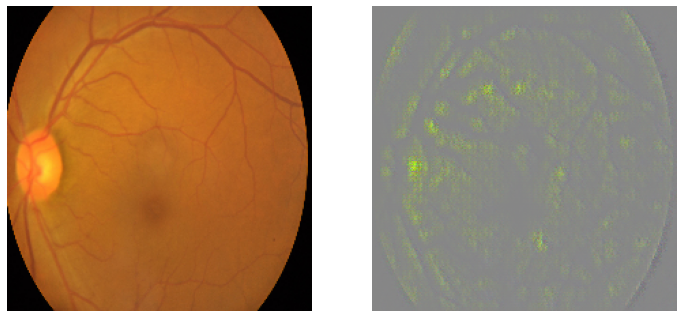

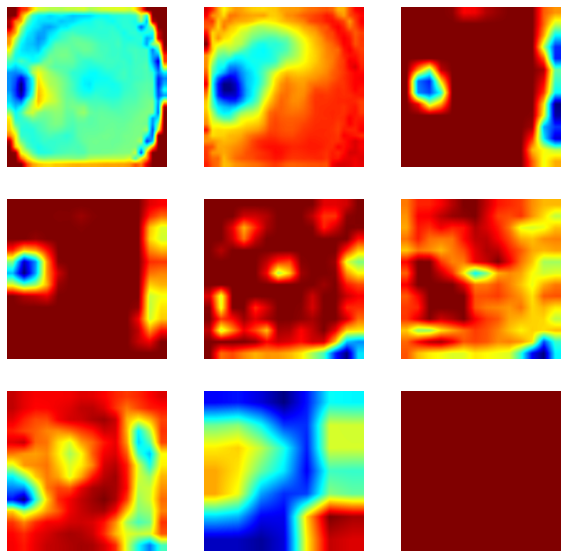

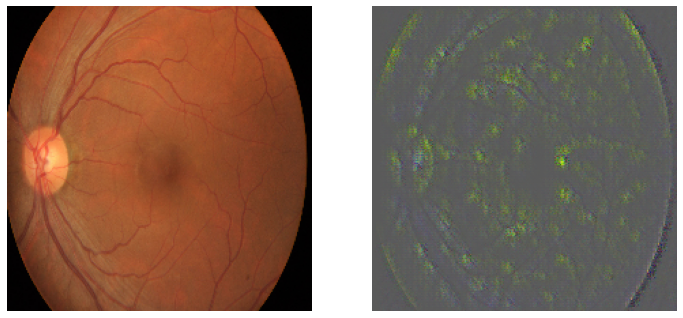

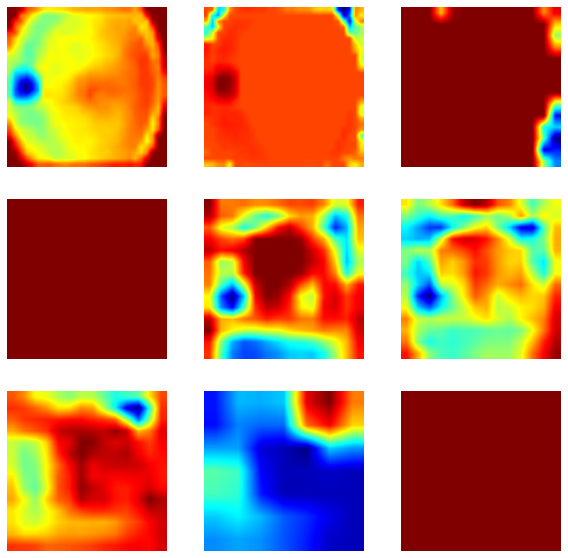

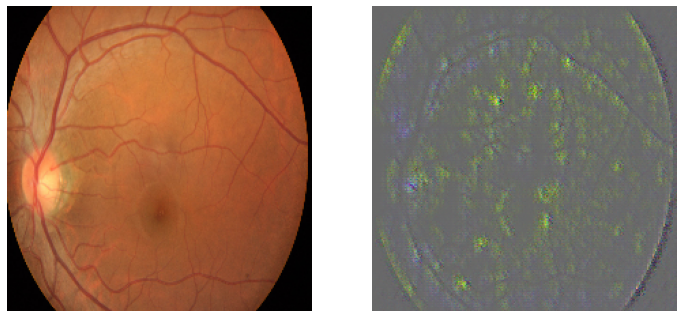

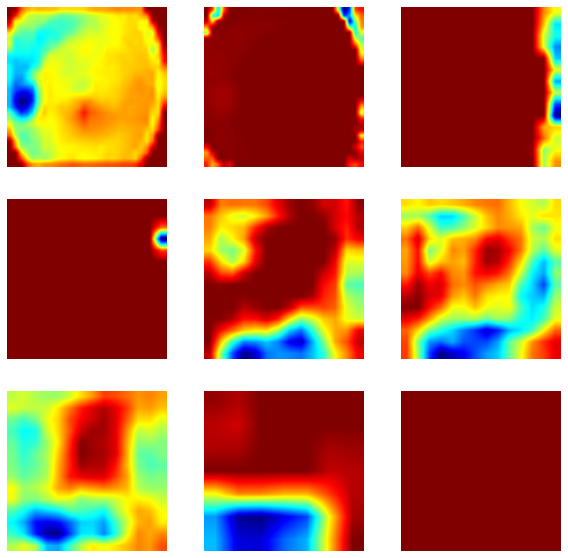

In [78]:
negatives = correct_eyes[correct_labels == 0]
for idx in random.sample(range(len(negatives)), 3):

  print(f"Negative Sample {idx}")
  input_img = negatives[idx]
  gcams, gbp = get_maps(model, input_img)

  plot_gbp(input_img, gbp)
  plot_gcams(gcams)

### Positives

Negative Sample 18
Negative Sample 54
Negative Sample 49


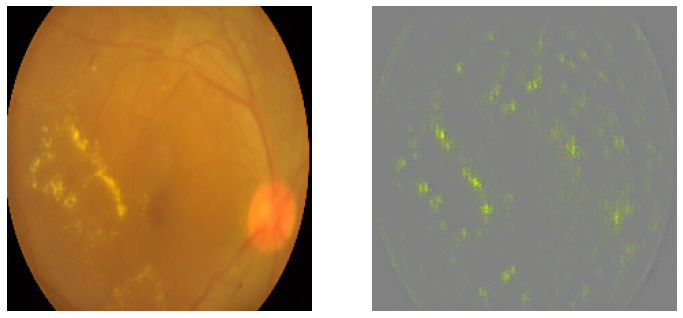

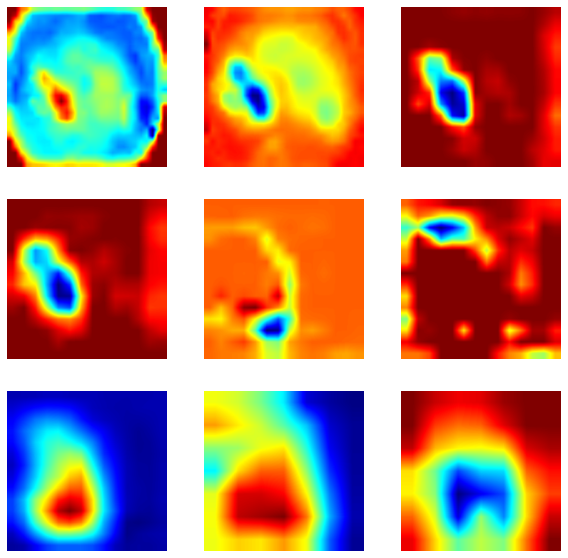

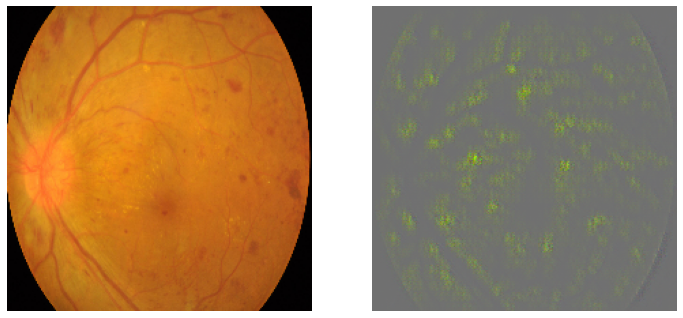

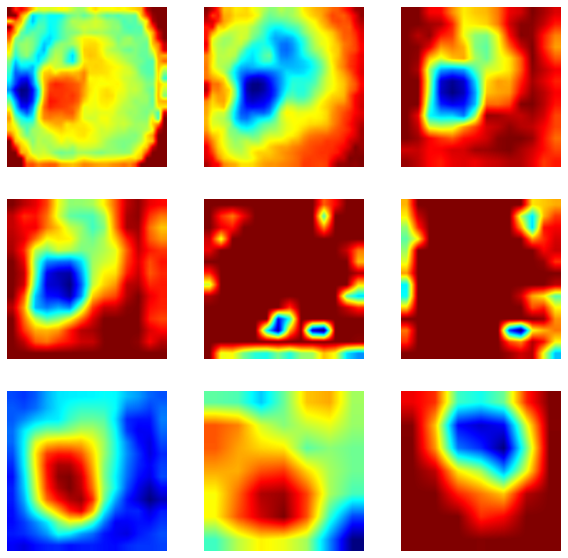

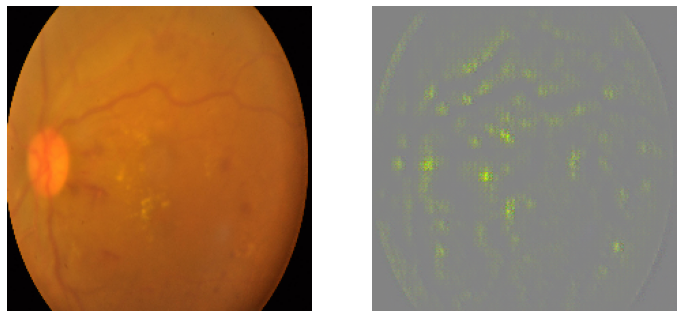

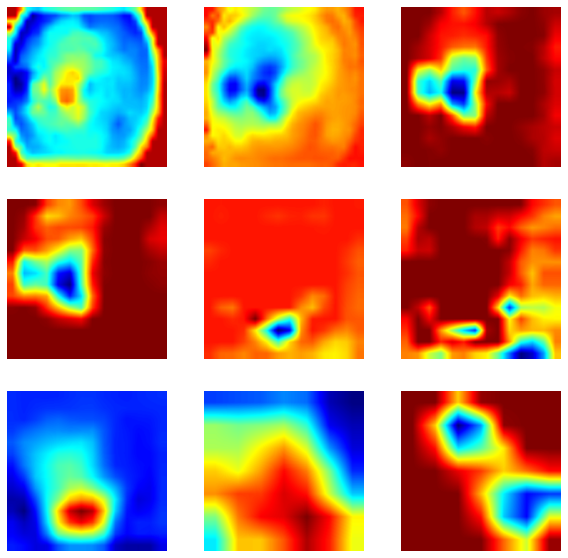

In [79]:
positives = correct_eyes[correct_labels == 1]
for idx in random.sample(range(len(positives)), 3):

  print(f"Positive Sample {idx}")
  input_img = positives[idx]
  gcams, gbp = get_maps(model, input_img)

  plot_gbp(input_img, gbp)
  plot_gcams(gcams)

### False Positives
Negative that are predicted as positives

Negative Sample 4
Negative Sample 2
Negative Sample 1


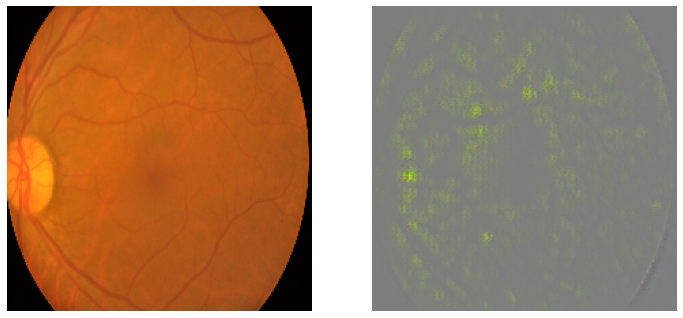

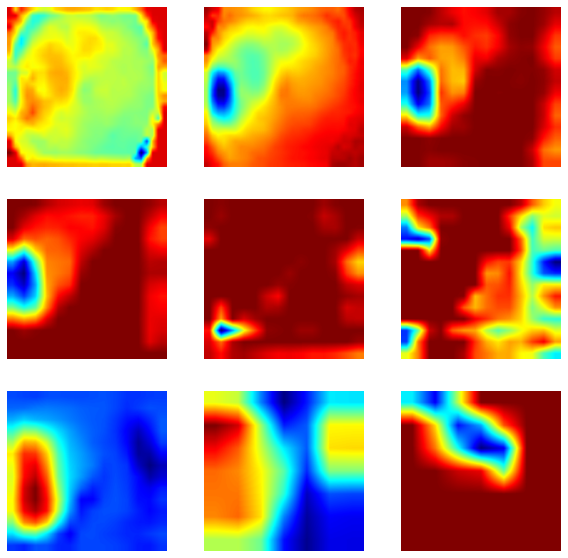

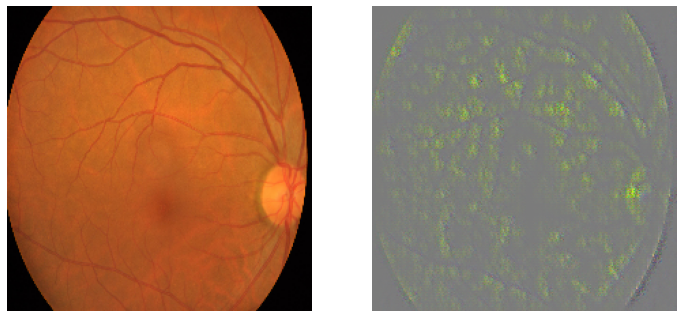

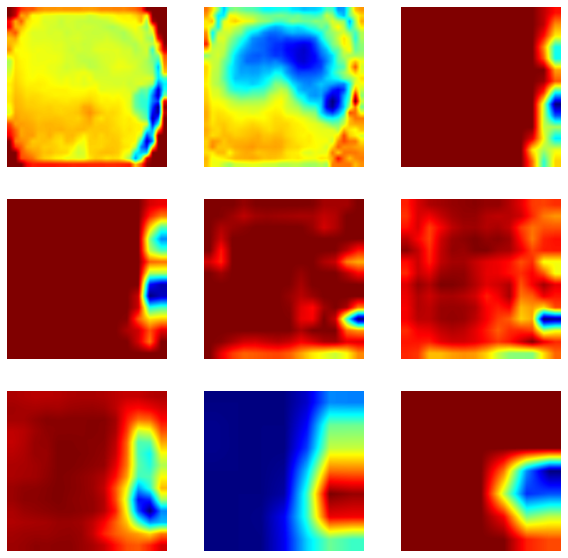

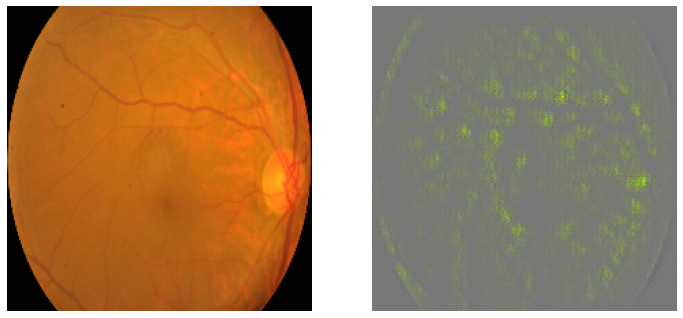

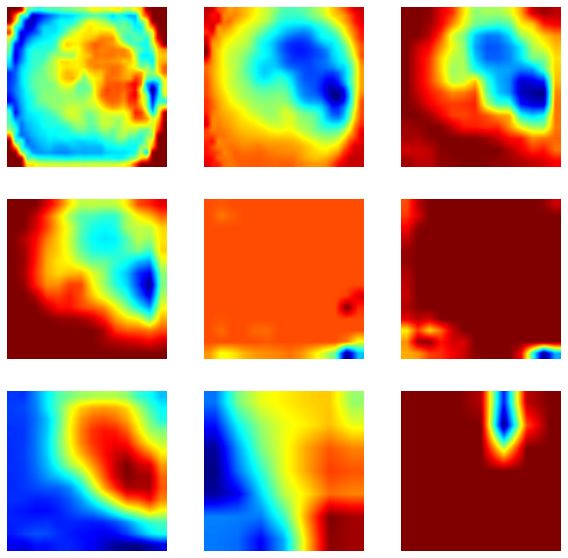

In [80]:
for idx in random.sample(range(len(fp_eyes)), 3):

  print(f"False Positive Sample {idx}")
  input_img = fp_eyes[idx]
  gcams, gbp = get_maps(model, input_img)

  plot_gbp(input_img, gbp)
  plot_gcams(gcams)

True Negative Sample 0


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:38: RuntimeWarning: invalid value encountered in true_divide


True Negative Sample 2
True Negative Sample 1


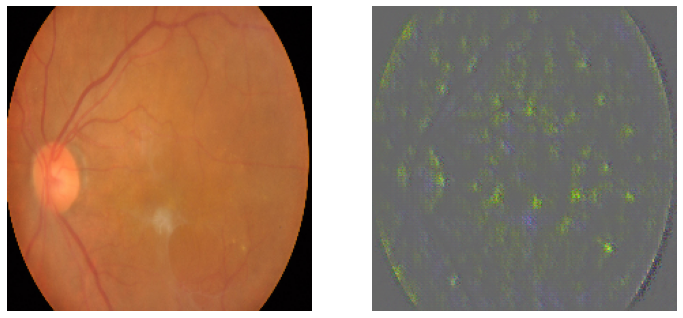

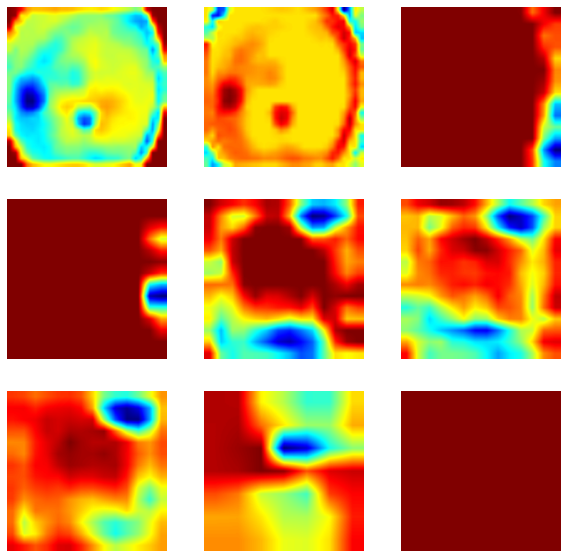

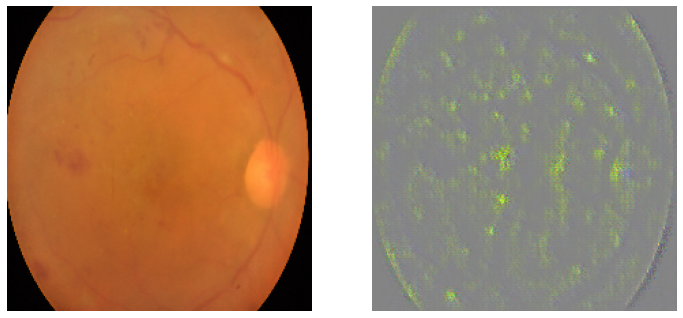

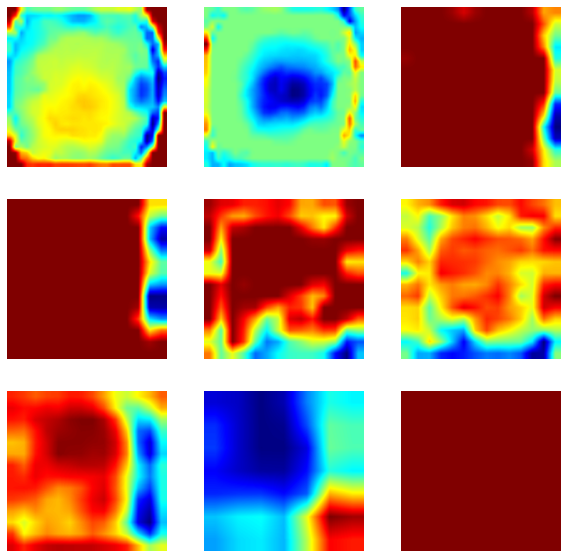

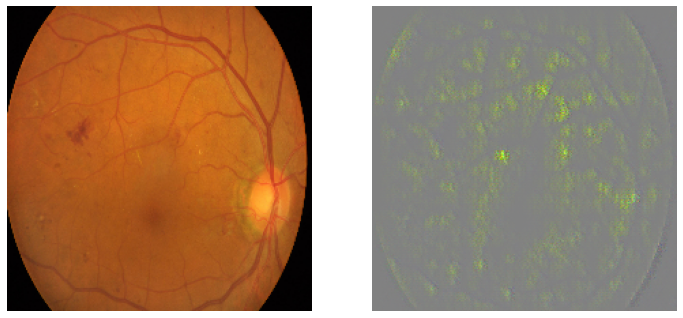

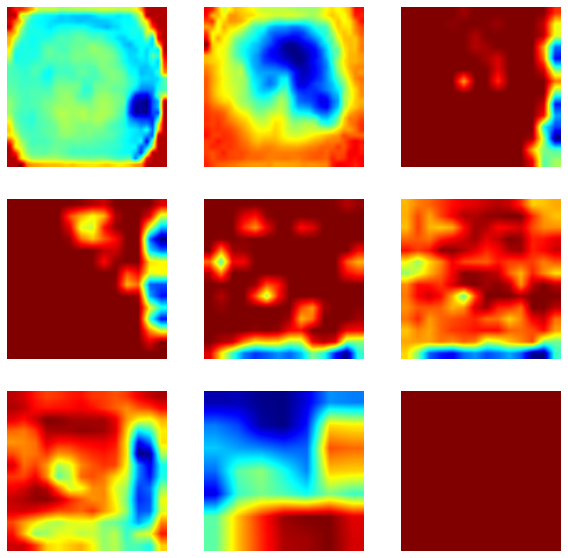

In [81]:
for idx in random.sample(range(len(tn_eyes)), 3):

  print(f"True Negative Sample {idx}")
  input_img = tn_eyes[idx]
  gcams, gbp = get_maps(model, input_img)

  plot_gbp(input_img, gbp)
  plot_gcams(gcams)